# 1. Load and Visualize the Dataset

## **Import** Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


In [2]:
from tqdm import tqdm

## Prepare the Data

In [3]:
# Définition des transformations : on ajoute du padding pour passer de 28x28 à 32x32 et on convertit en tenseur.
transform = transforms.Compose([
    transforms.Pad(2),      # Ajoute 2 pixels de padding de chaque côté
    transforms.ToTensor()     # Conversion en tensor PyTorch
])

batch_size = 128

# Chargement des datasets FashionMNIST (train et validation)
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
val_dataset   = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.12MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 61.6MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [21]:
len(train_dataset)

60000

## Visualizing Sample Images

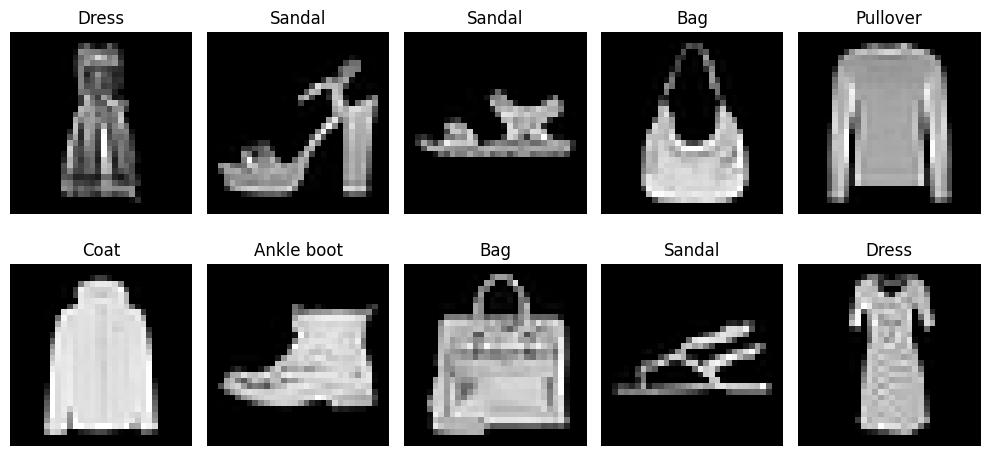

In [4]:
# Dictionnaire pour les labels de classes
class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

# Fonction pour visualiser un échantillon d'images
def plot_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy()
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(class_labels[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Affichage d'un exemple d'images
plot_sample_images(train_loader)

#  Build the Autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Autoencodeur avec un encodeur par convolution et un décodeur par convTranspose.
        input_shape : forme de l'image en entrée (ici, images en niveaux de gris 1x32x32)
        latent_dim  : dimension de l'espace latent (ici, 2 pour visualisation)
        """
        super(Autoencoder, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),  # Résultat : 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),                          # Résultat : 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),                         # Résultat : 128x4x4
            nn.ReLU()
        )

        # Calcul dynamique de la taille aplatie après l'encodeur
        self.flattened_size, self.decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # Projection dans l'espace latent
        self.fc_enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, latent_dim)
        )

        # Projection inverse : de l'espace latent vers la taille aplatie
        self.fc_dec = nn.Linear(latent_dim, self.flattened_size)

        # Décodeur : reconstruction à partir de la représentation aplatie
        self.decoder = nn.Sequential(
            nn.Unflatten(1, self.decode_shape[1:]),  # Remettre sous forme de tenseur 4D
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Pour avoir des sorties entre 0 et 1
        )

    def calculate_flattened_size(self, model, input_shape):
        """
        Calcule la taille aplatie après passage par l'encodeur.
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = model(dummy_input)
            flattened_size = output.numel()
            return flattened_size, output.shape  # retourne (nombre total d'éléments, forme de sortie)

    def forward(self, x):
        # Passage par l'encodeur
        encoded = self.encoder(x)
        # Projection dans l'espace latent
        latent = self.fc_enc(encoded)
        # Reconstruction : projection inverse puis décodeur
        decoded_input = self.fc_dec(latent)
        decoded = self.decoder(decoded_input)
        return decoded, latent


In [6]:
# Test de cohérence des dimensions
x_sample = torch.randn(1, 1, 32, 32)
model_test = Autoencoder(latent_dim=2)
image_test, latent_test = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Les dimensions de sortie ne correspondent pas aux dimensions d'entrée !"

# Train the Autoencoder

In [7]:
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    loss_fn = nn.MSELoss()
    total_ce_loss = 0
    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to(device)
            recon_x, _ = model(x)
            loss = loss_fn(recon_x, x)
            ce_loss = F.binary_cross_entropy(recon_x, x)
            total_loss += loss.item() * x.size(0)
            total_ce_loss += ce_loss.item() * x.size(0)
    avg_loss = total_loss / len(loader.dataset)
    avg_ce_loss = total_ce_loss / len(loader.dataset)
    return avg_loss, avg_ce_loss

def plot_training_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

# 4. Reconstruction d'images avec l'Autoencodeur

def plot_reconstructions(model, loader_or_tensor, ex=True):
    """
    Si ex==True, loader_or_tensor est un DataLoader et on utilise un batch d'images réelles.
    Sinon, loader_or_tensor est un tenseur de points latents.
    """
    model.eval()
    model = model.to("cpu")
    with torch.no_grad():
        if ex:
            for x, _ in loader_or_tensor:
                recon_x, _ = model(x)
                break
        else:
            latent = loader_or_tensor
            decoded_input = model.fc_dec(latent)
            recon_x = model.decoder(decoded_input)
            x = recon_x  # Dans ce cas, seules les reconstructions sont disponibles.

    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(5):
        if ex:
            plt.subplot(2, 5, i+1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")
        plt.subplot(2, 5, i+6)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconst.")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, epochs, learning_rate=0.0001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for x, _ in tqdm_loader:
            x = x.to(device)
            recon_x, _ = model(x)
            loss = loss_fn(recon_x, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)  # Accumuler la loss sur le batch
            tqdm_loader.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_val_loss, ce_loss = evaluate_model(model, val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Val CE Loss: {ce_loss:.6f}")

    plot_training_loss(train_losses, val_losses)

# Visualisation de l'espace latent

In [12]:
# 5. Visualisation de l'espace latent

def extract_embeddings(model, loader):
    model.eval()
    # Move the model to the device before extracting embeddings.
    model.to(device)  # Add this line to move the model to the device
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, latent = model(x)
            embeddings.append(latent.cpu().numpy())
            labels.append(y.numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

def plot_latent_space(embeddings, labels, class_labels):
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(10, 8))
    legend_handles = []
    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0]
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1],
                    c=[colors[i]], alpha=0.4, s=3, label=class_labels[label])
        legend_handles.append(Line2D([0], [0], marker='o', color='w',
                                     label=class_labels[label],
                                     markersize=10, markerfacecolor=colors[i]))
    plt.xlabel('Dimension latente 1')
    plt.ylabel('Dimension latente 2')
    plt.title('Visualisation de l\'espace latent en 2D')
    plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
    plt.show()

## Génération de nouvelles images via le décodeur

In [19]:
def generate_images(model, embeddings, n_samples=5):
    # Détermination des bornes de l'espace latent à partir des embeddings existants
    mins = np.min(embeddings, axis=0)
    maxs = np.max(embeddings, axis=0)
    samples = np.random.uniform(mins, maxs, size=(n_samples, embeddings.shape[1]))
    samples = torch.tensor(samples, dtype=torch.float32, device=next(model.parameters()).device)  # Move samples to the model's device

    model.eval()
    with torch.no_grad():
        decoded_input = model.fc_dec(samples)
        gen_images = model.decoder(decoded_input)

    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        # Move the tensor to the CPU before converting to NumPy
        plt.imshow(gen_images[i].cpu().squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle("Images générées")
    plt.show()

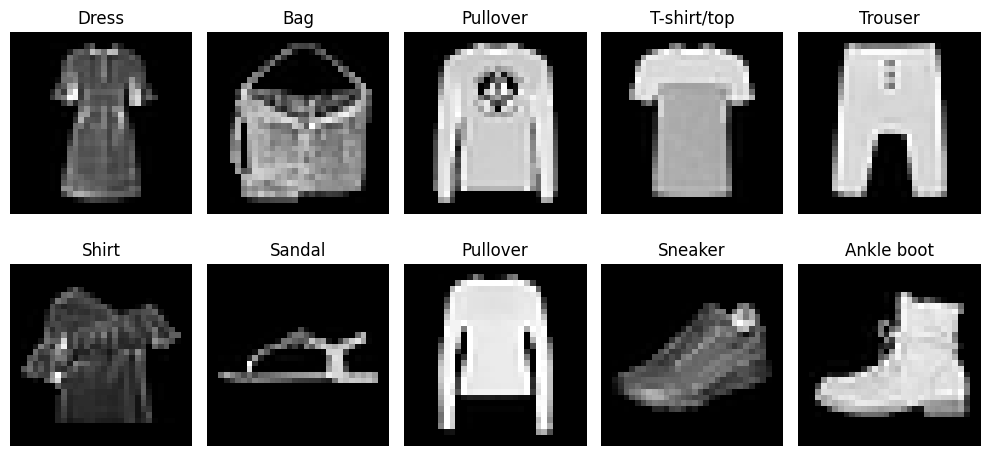

Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.86it/s]


Epoch [1/20], Train Loss: 0.068661, Val Loss: 0.040362, Val CE Loss: 0.311142


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 48.40it/s]


Epoch [2/20], Train Loss: 0.035568, Val Loss: 0.032697, Val CE Loss: 0.293463


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch [3/20], Train Loss: 0.032062, Val Loss: 0.031087, Val CE Loss: 0.290292


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.14it/s]


Epoch [4/20], Train Loss: 0.030771, Val Loss: 0.030298, Val CE Loss: 0.287444


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.12it/s]


Epoch [5/20], Train Loss: 0.029922, Val Loss: 0.029484, Val CE Loss: 0.284144


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.42it/s]


Epoch [6/20], Train Loss: 0.029277, Val Loss: 0.028762, Val CE Loss: 0.280985


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.27it/s]


Epoch [7/20], Train Loss: 0.028724, Val Loss: 0.028419, Val CE Loss: 0.279131


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.04it/s]


Epoch [8/20], Train Loss: 0.028262, Val Loss: 0.027971, Val CE Loss: 0.276933


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.90it/s]


Epoch [9/20], Train Loss: 0.027846, Val Loss: 0.027544, Val CE Loss: 0.274805


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 54.76it/s]


Epoch [10/20], Train Loss: 0.027516, Val Loss: 0.027225, Val CE Loss: 0.273671


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 52.82it/s]


Epoch [11/20], Train Loss: 0.027237, Val Loss: 0.026967, Val CE Loss: 0.272288


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 40.57it/s]


Epoch [12/20], Train Loss: 0.026971, Val Loss: 0.026728, Val CE Loss: 0.271375


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 54.26it/s]


Epoch [13/20], Train Loss: 0.026739, Val Loss: 0.026706, Val CE Loss: 0.270732


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.44it/s]


Epoch [14/20], Train Loss: 0.026548, Val Loss: 0.026401, Val CE Loss: 0.269845


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.05it/s]


Epoch [15/20], Train Loss: 0.026336, Val Loss: 0.026489, Val CE Loss: 0.269918


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.35it/s]


Epoch [16/20], Train Loss: 0.026180, Val Loss: 0.026052, Val CE Loss: 0.268600


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 55.48it/s]


Epoch [17/20], Train Loss: 0.026021, Val Loss: 0.025965, Val CE Loss: 0.268138


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 54.18it/s]


Epoch [18/20], Train Loss: 0.025846, Val Loss: 0.025664, Val CE Loss: 0.267019


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 53.36it/s]


Epoch [19/20], Train Loss: 0.025730, Val Loss: 0.025587, Val CE Loss: 0.267064


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 45.69it/s]


Epoch [20/20], Train Loss: 0.025588, Val Loss: 0.025426, Val CE Loss: 0.266296


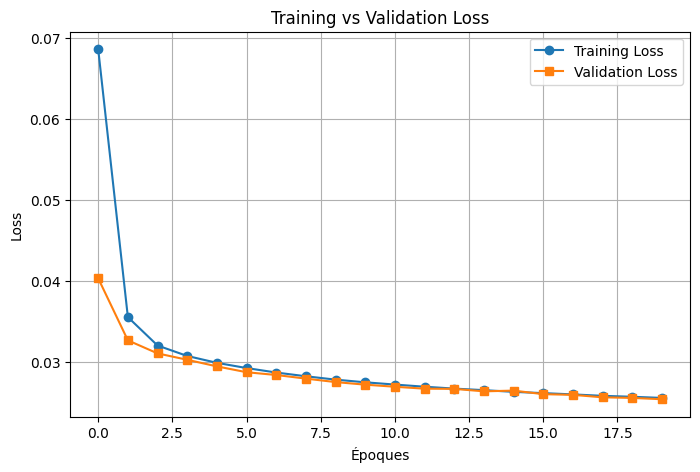

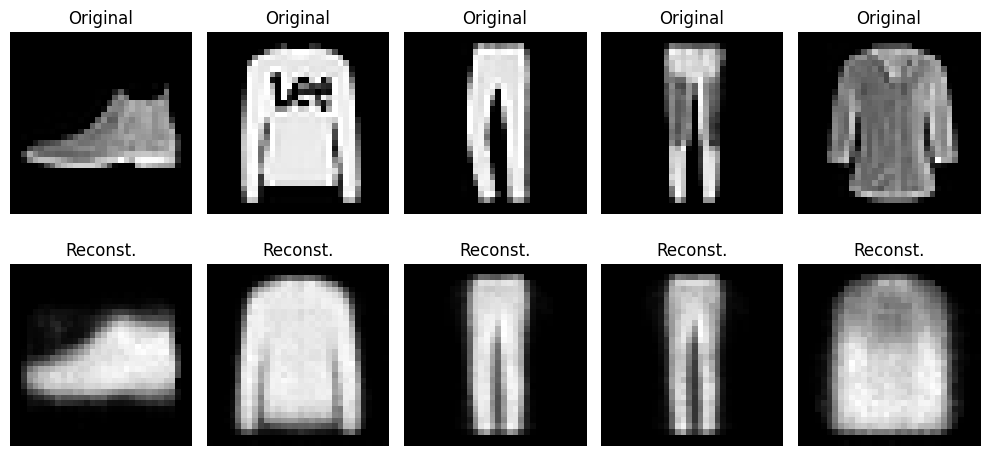

In [22]:
# ---------------------------
# Programme principal
# ---------------------------
if __name__ == "__main__":
    # Afficher quelques images d'exemple
    plot_sample_images(train_loader)

    # Instanciation du modèle avec un espace latent de dimension 2
    autoencoder = Autoencoder(latent_dim=2)

    # Vérification de la cohérence des dimensions
    x_sample = torch.randn(1, 1, 32, 32)
    image_test, latent_test = autoencoder(x_sample)
    assert image_test.shape == x_sample.shape, "Erreur de dimensions!"

    # Entraînement du modèle (par exemple sur 10 époques)
    epochs = 20
    train_model(autoencoder, train_loader, val_loader, epochs=epochs, learning_rate=0.0001)

    # Affichage des reconstructions sur quelques images de validation
    plot_reconstructions(autoencoder, val_loader, ex=True)



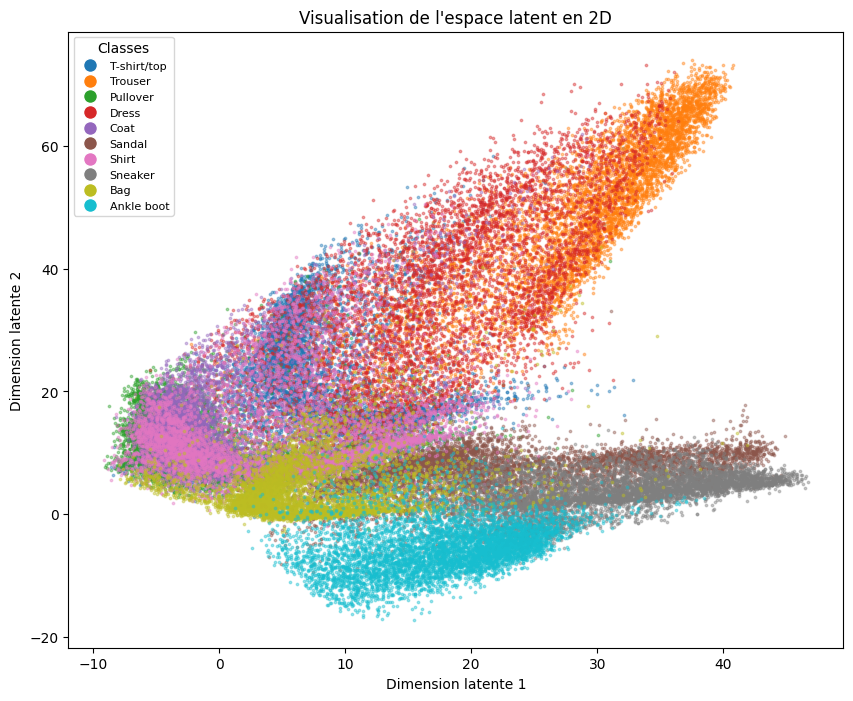

In [23]:
# Extraction et affichage de l'espace latent en 2D
embeddings, labels = extract_embeddings(autoencoder, train_loader)
plot_latent_space(embeddings, labels, class_labels)



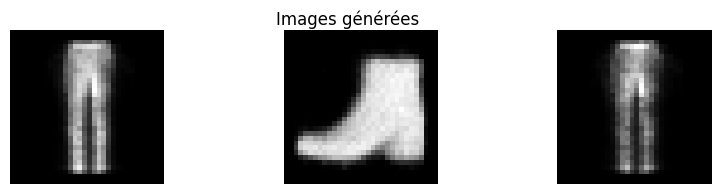

In [37]:
# Génération d'images à partir d'échantillons aléatoires dans l'espace latent
generate_images(autoencoder, embeddings, n_samples=3)

# Sauvegarde du modèle entraîné
torch.save(autoencoder.state_dict(), "VAmodel_state_dict.pth")